# ELMo and BERT Contextual Embeddings

In this notebook, we use contextual embeddings from ELMo/BERT to study semantic change of conversion.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition
import random
import scipy.stats

import src.corpus
import src.semantic_embedding

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Parse the corpus

In [2]:
#UD_PATH = '../data/ud_all/ud-treebanks-v2.5/'
#ud_files = src.corpus.group_treebanks_by_language(UD_PATH)
#corpus = src.corpus.POSCorpus.create_from_ud(data_file_list=ud_files['English'])

BNC_FILE = "../data/bnc/bnc.pkl"
corpus = src.corpus.POSCorpus.create_from_bnc_pickled(data_file_path=BNC_FILE)

## Compute embeddings on random part of the corpus

In [3]:
# Take only 1M words out of 4M to make it run faster
SAMPLE_PROPORTION = 1.0
random.seed(12345)
random_indices = random.sample(range(len(corpus.sentences)), int(SAMPLE_PROPORTION * len(corpus.sentences)))

sampled_sentences = []
for ix in random_indices:
  sampled_sentences.append(corpus.sentences[ix])
  
embedder = src.semantic_embedding.SemanticEmbedding(sampled_sentences)
embedder.init_bert(model_name='xlm-roberta-base', layer=12)

## Compute embeddings of instances of a fixed lemma

In [7]:
FIXED_LEMMA = "train"
noun_embeddings, verb_embeddings, noun_indices, verb_indices = embedder.get_bert_embeddings_for_lemma(FIXED_LEMMA)
print("Noun instances:", noun_embeddings.shape[0])
print("Verb instances:", verb_embeddings.shape[0])

Processing lemma: train (304 instances)
Noun instances: 212
Verb instances: 91


## Apply PCA and plot

In [8]:
pca = sklearn.decomposition.PCA(n_components=2)
all_embeddings = pca.fit_transform(np.vstack([noun_embeddings, verb_embeddings]))
all_embeddings_df = pd.DataFrame({'x0': all_embeddings[:,0], 'x1': all_embeddings[:,1]})
all_embeddings_df['pos'] = ['noun'] * len(noun_embeddings) + ['verb'] * len(verb_embeddings)
all_embeddings_df['sentence_ix'] = noun_indices + verb_indices

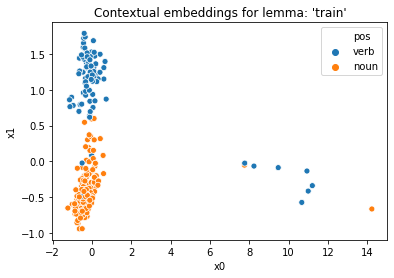

In [9]:
plot = sns.scatterplot(data=all_embeddings_df.sample(frac=1), x='x0', y='x1', hue='pos')
plot.set(title="Contextual embeddings for lemma: '%s'" % FIXED_LEMMA)
plt.show()

## Utility to inspect what it's capturing

In [11]:
num_printed = 0
for _, row in all_embeddings_df.iterrows():
  if row.x0 > 14: # <- Put whatever condition here
    sent = sampled_sentences[row.sentence_ix]
    print("POS=" + row.pos + ";", ' '.join([t['word'] for t in sent]))
    num_printed += 1
  if num_printed > 10:
    break

POS=noun; Train of Wars .


## Cosine similarity between noun and verb usages

In [7]:
lemma_count_df = corpus.get_per_lemma_stats()

# Filter: must have at least [x] noun and [x] verb usages
lemma_count_df = lemma_count_df[(lemma_count_df['noun_count'] >= 30) & (lemma_count_df['verb_count'] >= 30)]
lemma_count_df = lemma_count_df.sort_values('total_count', ascending=False)
#lemma_count_df = lemma_count_df[~lemma_count_df.lemma.isin(['go', 'will', 'may'])]
print('Remaining lemmas:', len(lemma_count_df))
print('Noun lemmas:', len(lemma_count_df[lemma_count_df.majority_tag == 'NOUN']))
print('Verb lemmas:', len(lemma_count_df[lemma_count_df.majority_tag == 'VERB']))

Remaining lemmas: 320
Noun lemmas: 172
Verb lemmas: 148


In [ ]:
lemma_count_df[['nv_cosine_similarity', 'n_variation', 'v_variation']] = \
  lemma_count_df.apply(lambda row: embedder.get_contextual_nv_similarity(row.lemma, method="bert"),
                       axis=1, result_type="expand")

In [9]:
lemma_count_df[['lemma', 'noun_count', 'verb_count', 'majority_tag', 'nv_cosine_similarity', 'n_variation', 'v_variation']] \
  .sort_values('nv_cosine_similarity').head(8)

,lemma,noun_count,verb_count,majority_tag,nv_cosine_similarity,n_variation,v_variation
4741,excuse,64,115,VERB,0.902674,2.110422,8.046687
2043,grant,108,87,NOUN,0.972677,6.938888,3.544248
11669,sue,39,66,VERB,0.979860,4.533002,2.139741
194,mind,736,620,NOUN,0.981725,1.830316,4.838988
72,part,1283,41,NOUN,0.984088,2.610144,2.661686
9025,row,326,47,NOUN,0.984933,2.084763,4.742203
1630,mark,562,198,NOUN,0.985929,6.456800,3.088658
1914,term,1063,40,NOUN,0.986137,2.243194,2.495466


In [10]:
lemma_count_df[['lemma', 'noun_count', 'verb_count', 'majority_tag', 'nv_cosine_similarity', 'n_variation', 'v_variation']] \
  .sort_values('nv_cosine_similarity', ascending=False).head(8)

,lemma,noun_count,verb_count,majority_tag,nv_cosine_similarity,n_variation,v_variation
1279,access,247,43,NOUN,0.998903,1.640107,1.510643
1617,control,519,179,NOUN,0.998878,1.841298,1.970525
4719,murder,296,62,NOUN,0.998837,1.865760,1.947399
6533,check,49,321,VERB,0.998836,2.053069,1.845442
1909,interview,185,63,NOUN,0.998789,1.840308,1.501519
188,paint,73,145,VERB,0.998737,1.709669,1.778917
2008,equal,47,38,NOUN,0.998702,2.041671,2.281623
119,attempt,302,214,NOUN,0.998680,1.889964,1.755515


## Difference in similarity when base is noun vs verb

/h/bai/moar/bai-conda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


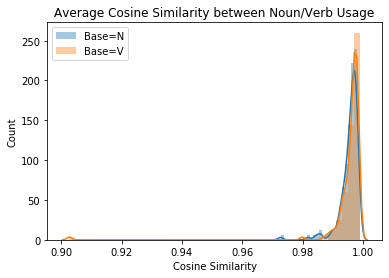

In [11]:
plot = sns.distplot(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity, label='Base=N')
plot = sns.distplot(lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity, label='Base=V')
plt.legend()
plot.set(title="Average Cosine Similarity between Noun/Verb Usage",
         xlabel="Cosine Similarity", ylabel="Count")
plt.show()

In [12]:
print('Mean cosine similarity when Base=N:', np.mean(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity))
print('Mean cosine similarity when Base=V:', np.mean(lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity))

Mean cosine similarity when Base=N: 0.9955181638861812
Mean cosine similarity when Base=V: 0.9954905441483936


In [13]:
# T-test of difference in mean
scipy.stats.ttest_ind(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity,
                      lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity)

Ttest_indResult(statistic=0.040916347542516156, pvalue=0.9673882617201648)

## Difference in variation between majority and minority class

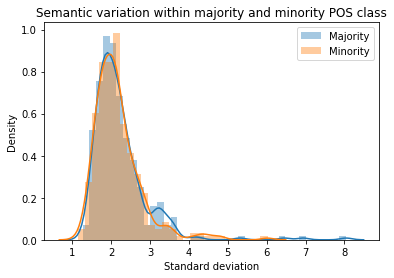

In [14]:
majority_variation = np.where(lemma_count_df.majority_tag == 'NOUN', lemma_count_df.n_variation, lemma_count_df.v_variation)
minority_variation = np.where(lemma_count_df.majority_tag == 'NOUN', lemma_count_df.v_variation, lemma_count_df.n_variation)
plot = sns.distplot(majority_variation, label='Majority')
plot = sns.distplot(minority_variation, label='Minority')
plt.legend()
plot.set(title="Semantic variation within majority and minority POS class",
         xlabel="Standard deviation", ylabel="Density")
plt.show()

In [15]:
print('Mean majority variation:', np.mean(majority_variation))
print('Mean minority variation:', np.mean(minority_variation))

Mean majority variation: 2.228868241235614
Mean minority variation: 2.1700905080884696


In [16]:
# Paired t-test for difference
scipy.stats.ttest_rel(majority_variation, minority_variation)

Ttest_relResult(statistic=1.094954584702522, pvalue=0.2743625603073653)